In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_embed=[512, 256, 128], 
                      d_quality=[512, 256, 1], 
                      n_heads=1,
                      lbd=1.).to('cuda')

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

Epoch 0001 Train MSE 2888.055 Validate MSE 1.040 Raw MSE 1.003
Epoch 0002 Train MSE 2888.048 Validate MSE 1.031 Raw MSE 0.995
Epoch 0003 Train MSE 2888.044 Validate MSE 1.013 Raw MSE 0.982
Epoch 0004 Train MSE 2888.068 Validate MSE 1.022 Raw MSE 0.996
Epoch 0005 Train MSE 2888.059 Validate MSE 1.041 Raw MSE 1.008
Epoch 0006 Train MSE 2888.047 Validate MSE 1.028 Raw MSE 1.002
Epoch 0007 Train MSE 2888.049 Validate MSE 1.036 Raw MSE 1.011
Epoch 0008 Train MSE 2888.038 Validate MSE 1.030 Raw MSE 1.008
Epoch 0009 Train MSE 2888.027 Validate MSE 1.016 Raw MSE 0.990
Epoch 0010 Train MSE 2888.045 Validate MSE 1.064 Raw MSE 1.042
Epoch 0011 Train MSE 2888.042 Validate MSE 1.047 Raw MSE 1.024
Epoch 0012 Train MSE 2888.047 Validate MSE 1.028 Raw MSE 1.008
Epoch 0013 Train MSE 2888.037 Validate MSE 1.040 Raw MSE 1.023
Epoch 0014 Train MSE 2888.031 Validate MSE 1.039 Raw MSE 1.025
Epoch 0015 Train MSE 2888.036 Validate MSE 1.063 Raw MSE 1.046
Epoch 0016 Train MSE 2888.019 Validate MSE 1.012 Raw MS

In [10]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 2887.985 Validate MSE 1.005 Raw MSE 1.036
Epoch 0502 Train MSE 2887.991 Validate MSE 0.967 Raw MSE 0.998
Epoch 0503 Train MSE 2887.974 Validate MSE 0.939 Raw MSE 0.980
Epoch 0504 Train MSE 2887.978 Validate MSE 0.961 Raw MSE 1.011


Epoch 0505 Train MSE 2887.962 Validate MSE 0.939 Raw MSE 0.993
Epoch 0506 Train MSE 2887.964 Validate MSE 0.920 Raw MSE 0.982
Epoch 0507 Train MSE 2887.960 Validate MSE 0.953 Raw MSE 1.019
Epoch 0508 Train MSE 2887.947 Validate MSE 0.957 Raw MSE 1.025
Epoch 0509 Train MSE 2887.953 Validate MSE 0.942 Raw MSE 1.021
Epoch 0510 Train MSE 2887.939 Validate MSE 0.936 Raw MSE 1.019
Epoch 0511 Train MSE 2887.927 Validate MSE 0.949 Raw MSE 1.032
Epoch 0512 Train MSE 2887.933 Validate MSE 0.951 Raw MSE 1.040
Epoch 0513 Train MSE 2887.935 Validate MSE 0.895 Raw MSE 0.973
Epoch 0514 Train MSE 2887.927 Validate MSE 0.922 Raw MSE 1.005
Epoch 0515 Train MSE 2887.925 Validate MSE 0.904 Raw MSE 0.997
Epoch 0516 Train MSE 2887.933 Validate MSE 0.915 Raw MSE 0.993
Epoch 0517 Train MSE 2887.931 Validate MSE 0.962 Raw MSE 1.063
Epoch 0518 Train MSE 2887.934 Validate MSE 0.915 Raw MSE 1.000
Epoch 0519 Train MSE 2887.932 Validate MSE 0.901 Raw MSE 0.980
Epoch 0520 Train MSE 2887.919 Validate MSE 0.946 Raw MS

In [11]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 2880.906 Validate MSE 0.868 Raw MSE 1.007
Epoch 1002 Train MSE 2860.026 Validate MSE 0.879 Raw MSE 1.029
Epoch 1003 Train MSE 2839.248 Validate MSE 0.873 Raw MSE 1.002
Epoch 1004 Train MSE 2818.547 Validate MSE 0.844 Raw MSE 0.983
Epoch 1005 Train MSE 2797.977 Validate MSE 0.871 Raw MSE 1.010


Epoch 1006 Train MSE 2777.484 Validate MSE 0.884 Raw MSE 1.020
Epoch 1007 Train MSE 2757.121 Validate MSE 0.866 Raw MSE 0.993
Epoch 1008 Train MSE 2736.826 Validate MSE 0.849 Raw MSE 0.995
Epoch 1009 Train MSE 2716.629 Validate MSE 0.870 Raw MSE 1.005
Epoch 1010 Train MSE 2696.527 Validate MSE 0.858 Raw MSE 1.003
Epoch 1011 Train MSE 2676.541 Validate MSE 0.847 Raw MSE 1.001
Epoch 1012 Train MSE 2656.621 Validate MSE 0.864 Raw MSE 0.994
Epoch 1013 Train MSE 2636.832 Validate MSE 0.858 Raw MSE 1.010
Epoch 1014 Train MSE 2617.108 Validate MSE 0.869 Raw MSE 1.026
Epoch 1015 Train MSE 2597.499 Validate MSE 0.882 Raw MSE 1.014
Epoch 1016 Train MSE 2577.953 Validate MSE 0.870 Raw MSE 1.008
Epoch 1017 Train MSE 2558.531 Validate MSE 0.853 Raw MSE 0.986
Epoch 1018 Train MSE 2539.228 Validate MSE 0.886 Raw MSE 1.034
Epoch 1019 Train MSE 2519.972 Validate MSE 0.895 Raw MSE 1.042
Epoch 1020 Train MSE 2500.849 Validate MSE 0.873 Raw MSE 0.997
Epoch 1021 Train MSE 2481.798 Validate MSE 0.865 Raw MS

Text(0, 0.5, 'MSE')

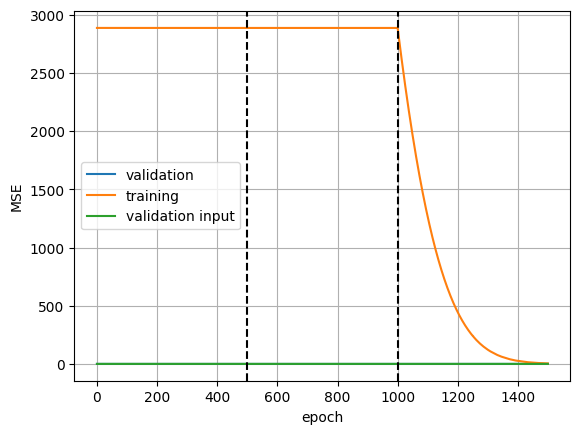

In [12]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [13]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.039905,pre-denoise
1,1,1.031261,pre-denoise
2,2,1.013457,pre-denoise
3,3,1.022297,pre-denoise
4,4,1.041150,pre-denoise
...,...,...,...
1495,1495,0.830571,denoise-smooth-enhance
1496,1496,0.830138,denoise-smooth-enhance
1497,1497,0.837765,denoise-smooth-enhance
1498,1498,0.834210,denoise-smooth-enhance


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


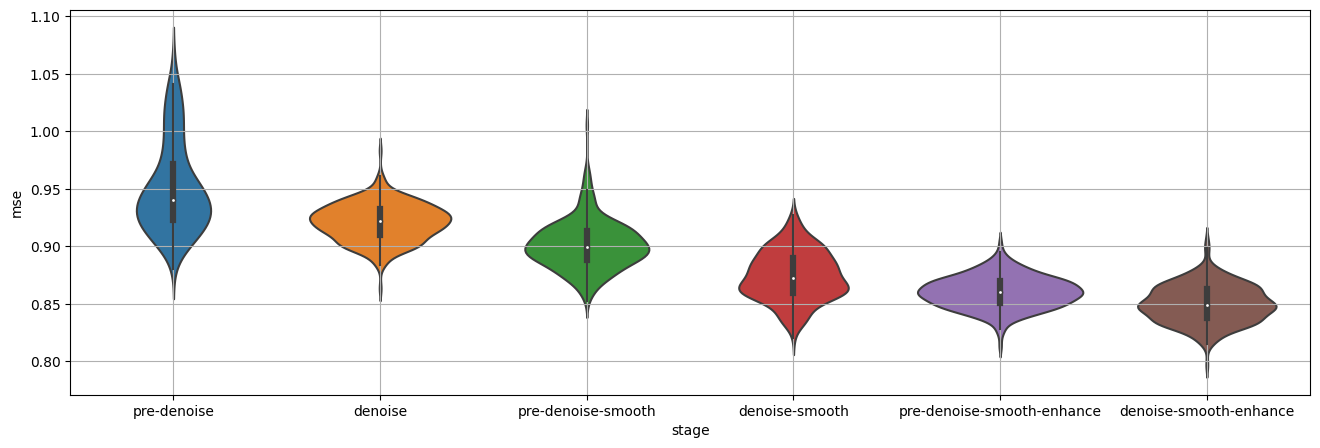

In [14]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [15]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 3.938442422524234e-70 f = 0.957568


In [16]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 1.4856790707762623e-33 f = 0.812016


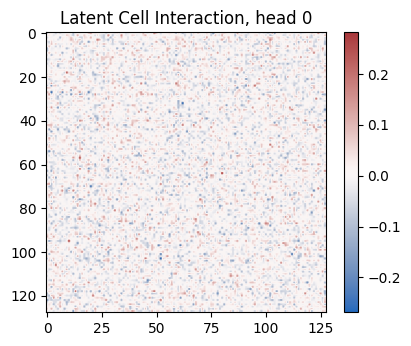

In [17]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

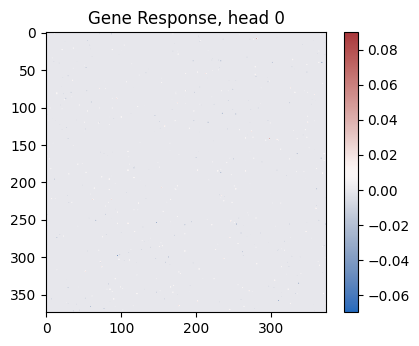

In [18]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

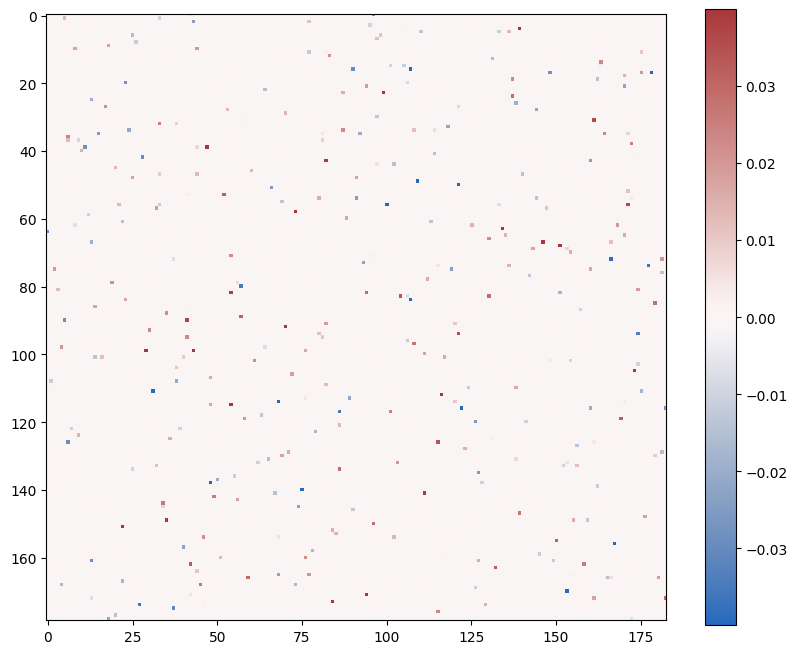

In [31]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag')
plt.colorbar()

In [33]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000018381', 'ENSMUSG00000035783', 'ENSMUSG00000017390',
        'ENSMUSG00000038115', 'ENSMUSG00000037010', 'ENSMUSG00000031375',
        'ENSMUSG00000036887', 'ENSMUSG00000073418', 'ENSMUSG00000027559',
        'ENSMUSG00000019997',
        ...
        'ENSMUSG00000028370', 'ENSMUSG00000031839', 'ENSMUSG00000055761',
        'ENSMUSG00000040612', 'ENSMUSG00000038872', 'ENSMUSG00000050711',
        'ENSMUSG00000044647', 'ENSMUSG00000097648', 'ENSMUSG00000024238',
        'ENSMUSG00000025754'],
       dtype='object', length=183),
 Index(['ENSMUSG00000018381', 'ENSMUSG00000035783', 'ENSMUSG00000020178',
        'ENSMUSG00000036777', 'ENSMUSG00000024411', 'ENSMUSG00000060802',
        'ENSMUSG00000031375', 'ENSMUSG00000021835', 'ENSMUSG00000024164',
        'ENSMUSG00000027559',
        ...
        'ENSMUSG00000055415', 'ENSMUSG00000041959', 'ENSMUSG00000053007',
        'ENSMUSG00000025357', 'ENSMUSG00000040612', 'ENSMUSG00000020160',
        'ENSMUSG00000044647', 'ENSM

In [36]:
meaningfulMatGR.shape

(179, 183)

([<matplotlib.axis.YTick at 0x7f093af35850>,
 [Text(0, 0, 'ENSMUSG00000002603'),
  Text(0, 1, 'ENSMUSG00000003184'),
  Text(0, 2, 'ENSMUSG00000042589'),
  Text(0, 3, 'ENSMUSG00000023886'),
  Text(0, 4, 'ENSMUSG00000024598'),
  Text(0, 5, 'ENSMUSG00000019772'),
  Text(0, 6, 'ENSMUSG00000015839'),
  Text(0, 7, 'ENSMUSG00000097462'),
  Text(0, 8, 'ENSMUSG00000055639'),
  Text(0, 9, 'ENSMUSG00000048583')])

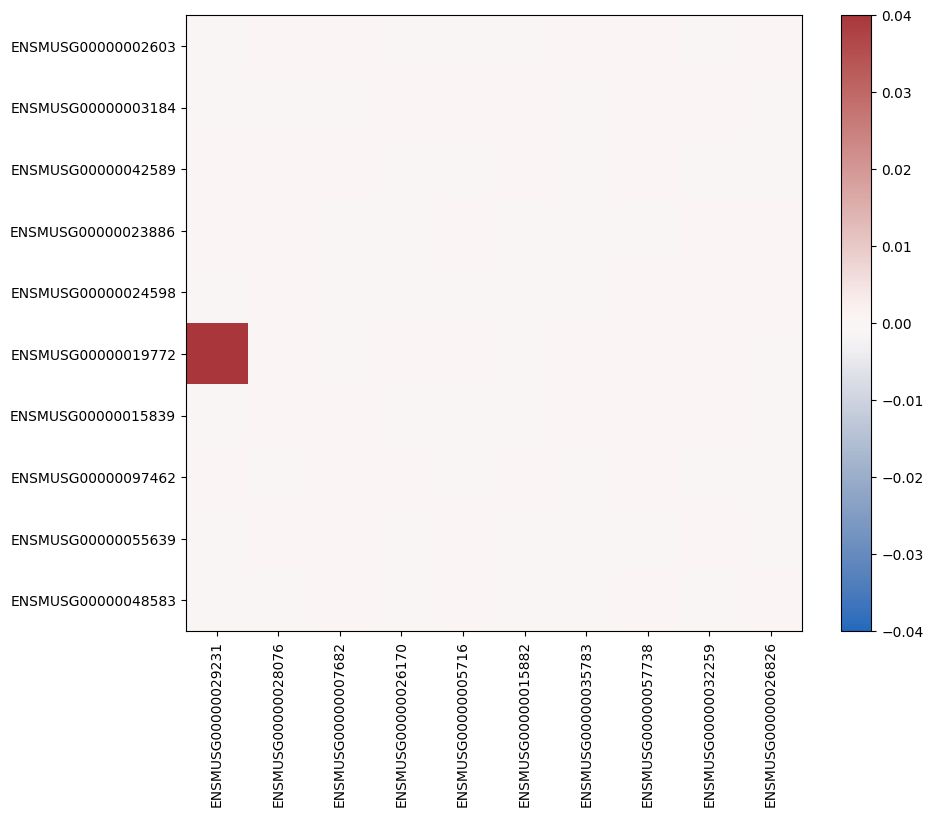

In [49]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [50]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)